In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc3 as pm
from datetime import datetime as dt

sns.set_style('whitegrid')

In [4]:
df = pd.read_csv("./data/Price/Task 1/Task1_P.csv")

# cleaning
df.columns = ['zone_id','timestamp','system_load','zonal_load','price']
df['timestamp'] = df.timestamp.apply(lambda x: dt.strptime(x, '%m%d%Y %H:%M'))
df['day'] = df.timestamp.dt.date
df['hour'] = df.timestamp.dt.hour
df['weekday'] = df.timestamp.dt.weekday

# set main datetime index
df = df.set_index('timestamp')

<AxesSubplot:xlabel='timestamp'>

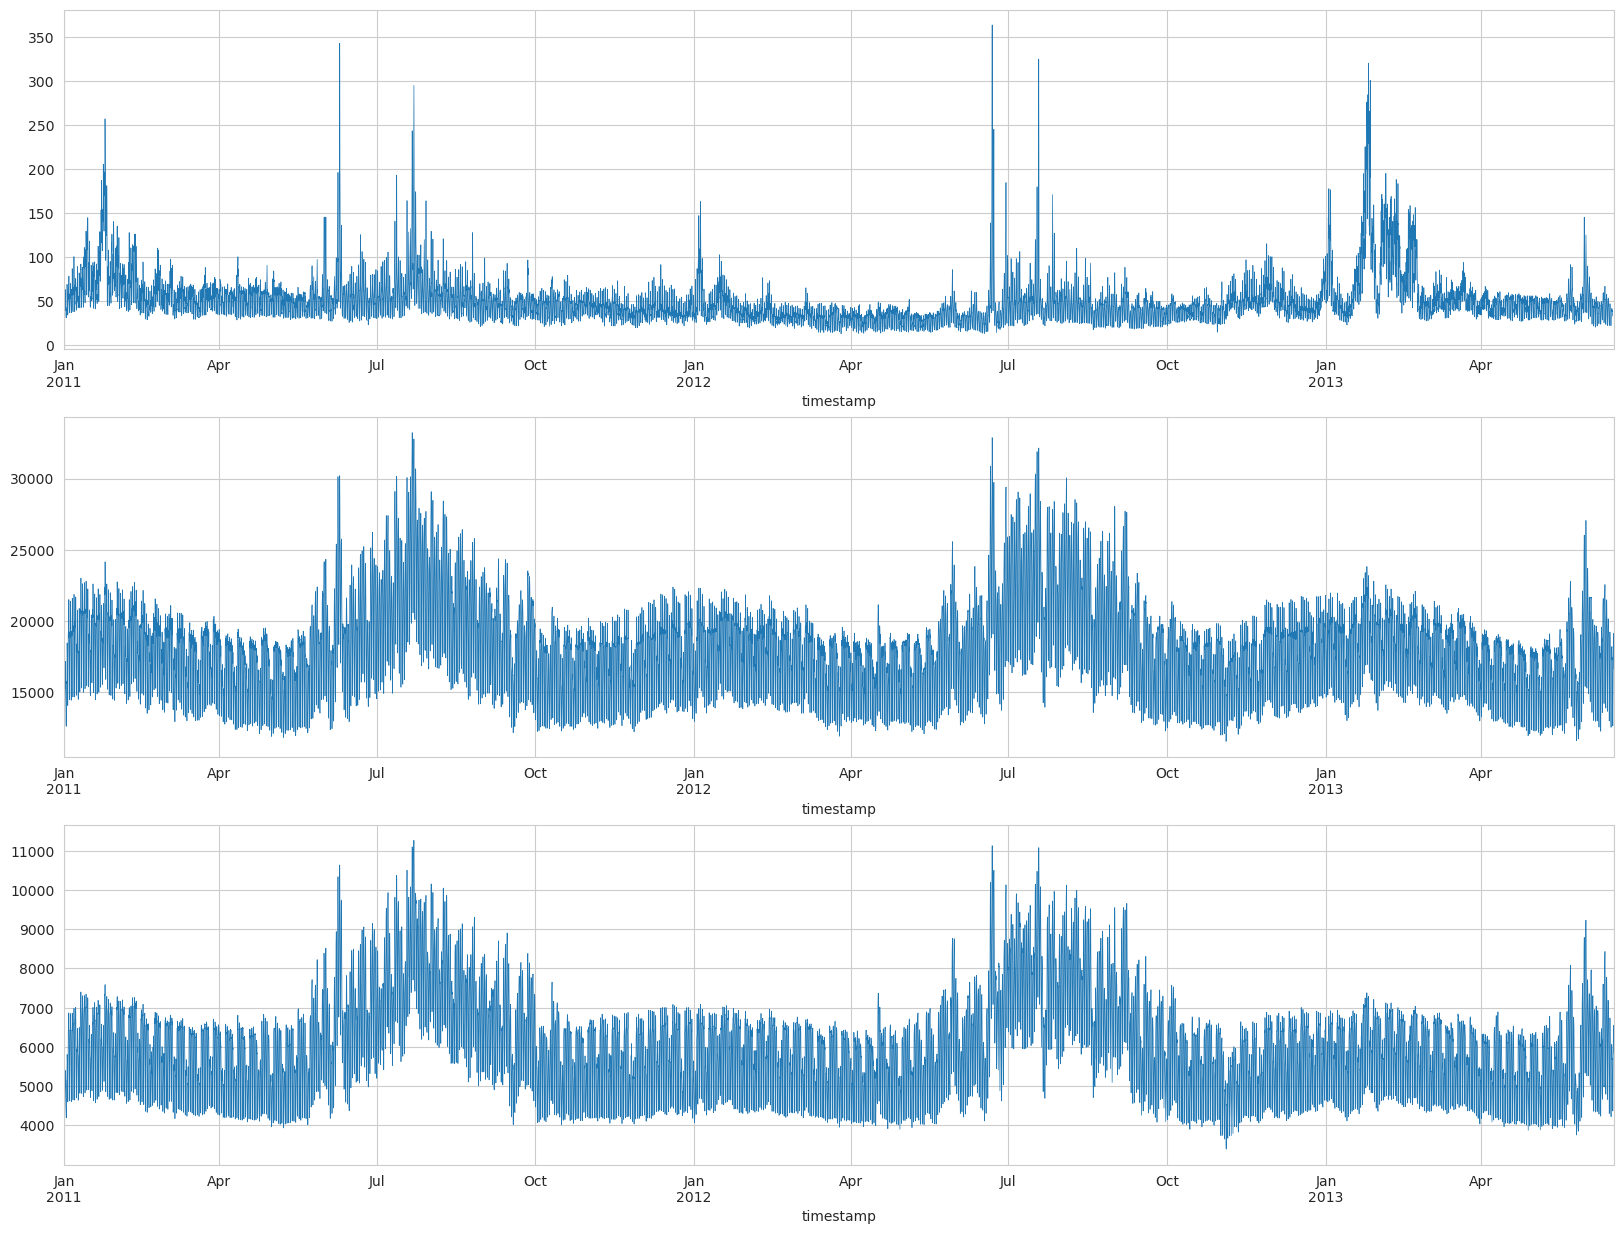

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15))
df.price.plot(ax=axes[0], lw=0.5)
df.system_load.plot(ax=axes[1], lw=0.5)
df.zonal_load.plot(ax=axes[2], lw=0.5)

In [15]:
def crps(x_hats, x, qs):
    """
    Continuous Ranked Probability Score
    Estimated using discretization of Pinball Scores at each quantile
    
    paramters:
    ----------
    x: float, the realization observed
    x_hats: array of float, the prediction of x at all q-th quantile from 1% to 99%
    qs: array of float, the q-th quantiles ∈ [0, 1] predictions provided
    """
    errors = np.abs(x - x_hats)
    weights = np.where(x >= x_hats, qs, 1-qs)
    return (errors * weights).sum()

def unconditional_coverage(y_true, y_lbs, y_ubs):
    """
    Unconditional Coverage of a quantile bound

    parameters:
    -----------
    y_true: array of float, the true observations
    y_lbs: array of float, the predicted lower bounds
    y_ubs: array of float, the predicted upper bounds
    """
    # remove any entry that is nan
    has_nan = np.isnan(y_true) | np.isnan(y_lbs) | np.isnan(y_ubs)
    is_covered = ((y_true >= y_lbs) & (y_true <= y_ubs))[~has_nan]
    return np.mean(is_covered)

### Benchmark Algorithm

In [16]:
# set up benchmark - naive
naive = df.copy()
naive['last_week_price'] = naive.shift(24*7).price
naive['last_day_price'] = naive.shift(24).price
naive['price_predict'] = naive.apply(lambda x: x.last_day_price if x.weekday in (1,2,3,4) else x.last_week_price, axis=1)

window_size = 182
qs = np.linspace(1, 99, 99) / 100

# rolling PI window estimation, done indepdently per hour
stats = []
for hour in range(24):
    window = naive[naive.hour==hour].rolling(window_size+1, min_periods=window_size+1)
    
    for chunk in window:
        ts = chunk.index[-1]

        # window chunk with not enough data
        if chunk.shape[0] != (window_size+1):
            stats.append((ts, np.nan, np.nan, np.nan))
            continue

        # chunk with enough data
        y_hat = chunk.price_predict.iloc[-1]
        chunk_history = chunk.iloc[:-1]
        y_hats = (chunk_history.price - chunk_history.price_predict).quantile(qs).values + y_hat

        y = chunk.price.iloc[-1]
        if np.isnan(y):
            stats.append((ts, y_hats[4], y_hats[94], np.nan))
        else:
            stats.append((ts, y_hats[4], y_hats[94], crps(y_hats, y, qs)))

naive[['predict_q5','predict_q95', 'crps']] = pd.DataFrame(stats, columns=['timestamp', 'predict_q5', 'predict_q95', 'crps']).set_index('timestamp')
naive['predict_uc'] = (naive.price <= naive.predict_q95) & (naive.price >= naive.predict_q5)

In [611]:
unconditional_coverage(naive.price, naive.predict_q5, naive.predict_q95)

0.8796037296037296

<AxesSubplot:xlabel='hour'>

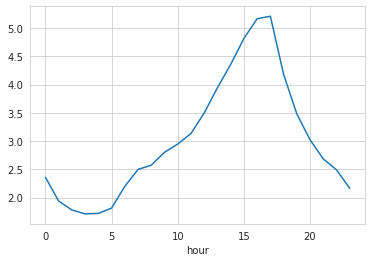

In [662]:
(naive.groupby('hour').crps.mean() / qs.shape[0]).plot()

<AxesSubplot:xlabel='hour'>

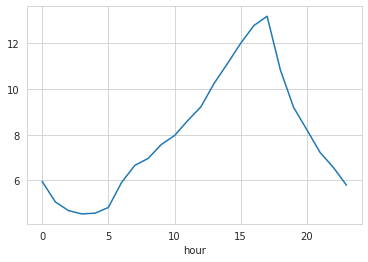

In [613]:
naive.groupby('hour').apply(lambda x: np.abs(x.price - x.price_predict).mean()).plot()

<AxesSubplot:xlabel='timestamp'>

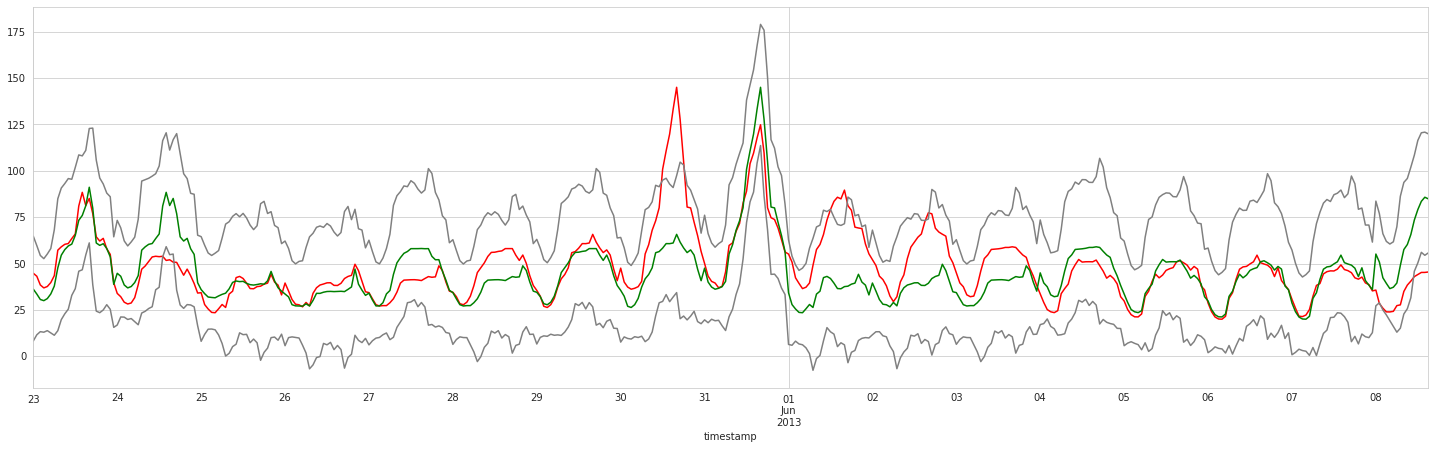

In [655]:
fig, ax = plt.subplots(figsize=(25, 7))
naive.iloc[-600:-200, :].price.plot(color='red')
naive.iloc[-600:-200, :].price_predict.plot(color='green')
naive.iloc[-600:-200, :].predict_q95.plot(color='grey')
naive.iloc[-600:-200, :].predict_q5.plot(color='grey')

### ARX Model Prediction

In [17]:
arx = df.copy()

In [18]:
window_size = 365

arx['log_price'] = np.log(arx.price)
arx['log_zonal_load'] = np.log(arx.zonal_load)
# hourly indepdent simple moving average of the last window used current estimation
arx['yearly_logmean'] = arx.groupby('hour').rolling(window=window_size+1, min_periods=window_size).price.apply(lambda x: np.mean(np.log(x.iloc[:-1]))).droplevel(0)
arx['centered_log_price'] = arx.log_price - arx.yearly_logmean

arx['clp[-1 day]'] = arx.centered_log_price.shift(24*1)
arx['clp[-2 day]'] = arx.centered_log_price.shift(24*2)
arx['clp[-7 day]'] = arx.centered_log_price.shift(24*7)

arx['clp[-1 day]min'] = arx.groupby('day')['clp[-1 day]'].min()
arx['clp[-1 day]min'] = arx['clp[-1 day]min'].fillna(method='ffill')

arx['is_sat'] = (arx.weekday == 5).astype(int)
arx['is_sun'] = (arx.weekday == 6).astype(int)
arx['is_mon'] = (arx.weekday == 0).astype(int)

In [19]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

feature_cols = ['clp[-1 day]', 'clp[-2 day]', 'clp[-7 day]', 'clp[-1 day]min', 'is_sat', 'is_sun', 'is_mon', 'log_zonal_load']
step = 1
pred_horizon = step
start_t = (365 + 6) * step
training_t = 182 * step

# the nested training and prediction procedure
stats = []
for hour in range(24):
    a = arx[arx.hour==hour].iloc[start_t:, :]
    for i in range(int((a.shape[0]-training_t) // step)):
        start = step*i
        end = start + training_t

        ts = a.index[end+pred_horizon-1]

        X_train = a[feature_cols].iloc[start:end, :]
        y_train = a['centered_log_price'].iloc[start:end]
        y_train_intercept = a['yearly_logmean'].iloc[start:end]

        X_test = a[feature_cols].iloc[end:end+pred_horizon, :]
        y_test_intercept = a['yearly_logmean'].iloc[end:end+pred_horizon].values
        y_true = a.price.iloc[end:end+pred_horizon]

        ols = LinearRegression(fit_intercept=False)
        ols.fit(X_train, y_train)

        y_res = np.exp(pd.Series(ols.predict(X_train).ravel(), index=X_train.index) + y_train_intercept) - np.exp(y_train + y_train_intercept)
        y_hat = np.exp(ols.predict(X_test) + y_test_intercept)[0]
        y_qs = y_res.quantile(qs).values + y_hat
        stats.append((ts, y_hat, y_qs[4], y_qs[94], crps(y_qs, y_true[0], qs)))

arx[['price_predict', 'predict_q5','predict_q95', 'crps']] = pd.DataFrame(stats, columns=['timestamp', 'price_predict', 'predict_q5', 'predict_q95', 'crps']).set_index('timestamp')
arx['predict_uc'] = (arx.price <= arx.predict_q95) & (arx.price >= arx.predict_q5)

In [661]:
unconditional_coverage(arx.price, arx.predict_q5, arx.predict_q95)

0.8390261627906976

Text(0.5, 1.0, 'CRPS')

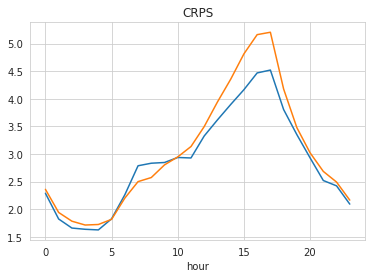

In [663]:
(arx.groupby('hour').crps.mean() / qs.shape[0]).plot()
(naive.groupby('hour').crps.mean() / qs.shape[0]).plot()
plt.title('CRPS')

Text(0.5, 1.0, 'MAE')

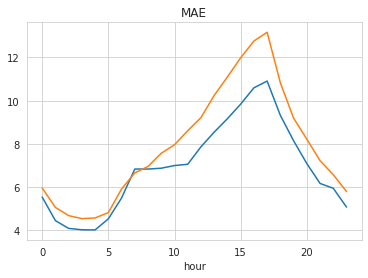

In [648]:
arx.groupby('hour').apply(lambda x: np.abs(x.price - x.price_predict).mean()).plot()
naive.groupby('hour').apply(lambda x: np.abs(x.price - x.price_predict).mean()).plot()
plt.title('MAE')

In [1]:
fig, ax = plt.subplots(figsize=(25, 7))
arx.iloc[-600:-200, :].price.plot(color='green')
arx.iloc[-600:-200, :].price_predict.plot(color='orange')
arx.iloc[-600:-200, :].predict_q95.plot(color='grey', linestyle=':')
arx.iloc[-600:-200, :].predict_q5.plot(color='grey', linestyle=':')

NameError: name 'plt' is not defined

<AxesSubplot:xlabel='timestamp'>

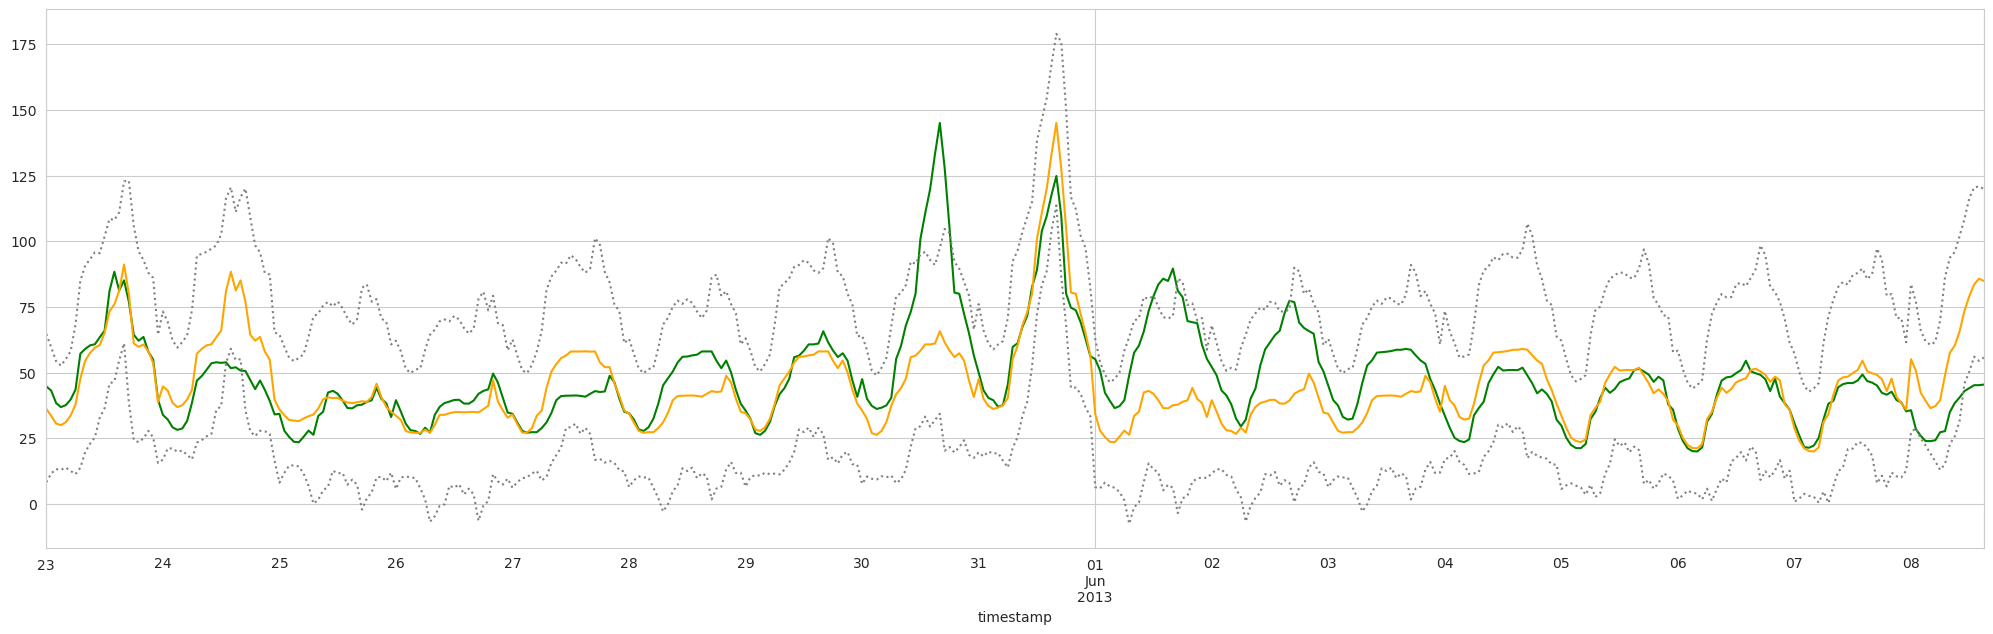

In [21]:
fig, ax = plt.subplots(figsize=(25, 7))
naive.iloc[-600:-200, :].price.plot(color='green')
naive.iloc[-600:-200, :].price_predict.plot(color='orange')
naive.iloc[-600:-200, :].predict_q95.plot(color='grey', linestyle=':')
naive.iloc[-600:-200, :].predict_q5.plot(color='grey', linestyle=':')

### GM-HMM

### Some analysis

<AxesSubplot:xlabel='zonal_load', ylabel='price'>

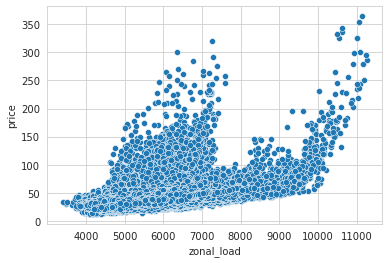

In [133]:
sns.scatterplot(data=df, x='zonal_load', y='price')

<AxesSubplot:xlabel='0', ylabel='Density'>

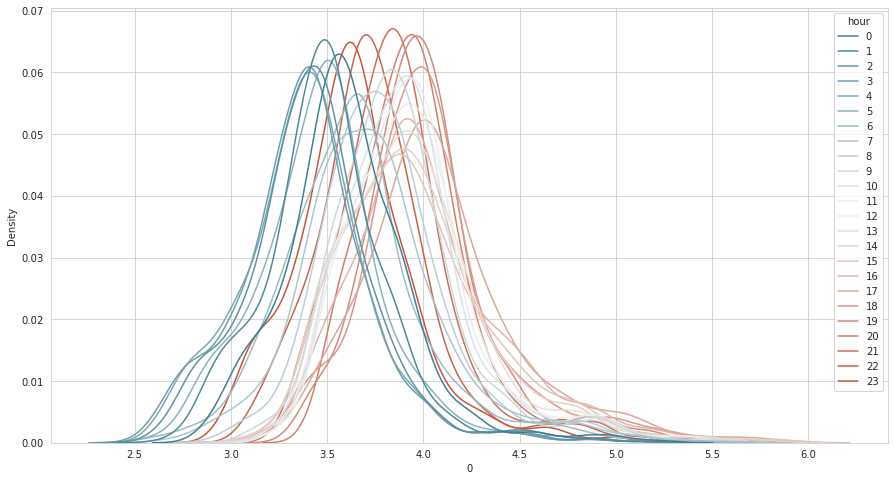

In [8]:
a = df.set_index(['day','hour']).loc[:, ['system_load','zonal_load','price']].unstack(level=1)

fig, ax = plt.subplots(figsize=(15, 8))
sns.kdeplot(data=np.log(a.price).stack().reset_index(), x=0, hue='hour', ax=ax, palette=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot:xlabel='hour', ylabel='0'>

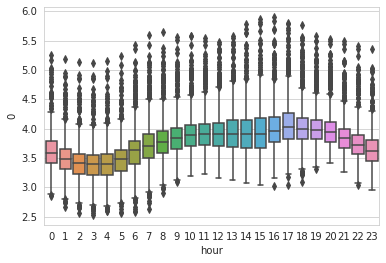

In [10]:
sns.boxplot(data=np.log(a.price).stack().reset_index(), y=0, x='hour')

<AxesSubplot:xlabel='hour', ylabel='hour'>

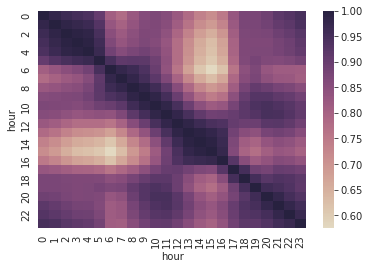

In [18]:
sns.heatmap(np.log(a.price).corr(), cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

<AxesSubplot:xlabel='timestamp'>

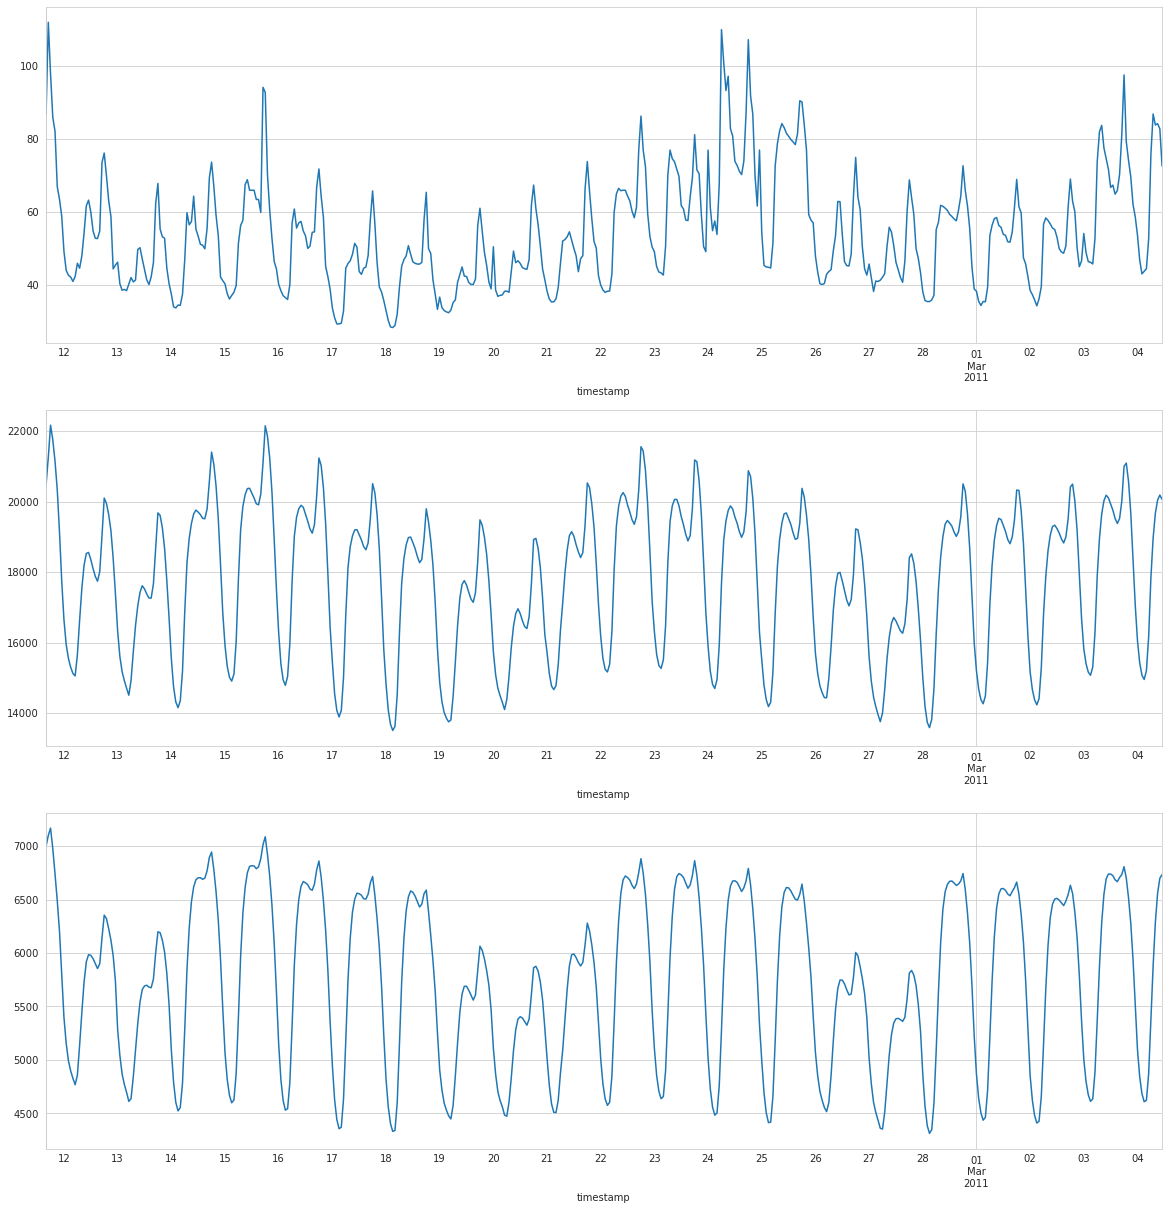

In [49]:
n1, n2 = 1000, 1500
fig, axes = plt.subplots(3, 1, figsize=(20, 21))
df.iloc[n1:n2, :].price.plot(ax=axes[0])
df.iloc[n1:n2, :].system_load.plot(ax=axes[1])
df.iloc[n1:n2, :].zonal_load.plot(ax=axes[2])